In [1]:
# import potrzebnych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter

#nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# system
import os
import shutil

# tf
import tensorflow as tf

#gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

#wordcloud 
from wordcloud import WordCloud 

#filter warnings
import warnings
warnings.filterwarnings('ignore')

#ML models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **1B - Dane i preprocesowanie**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_raw=pd.read_csv('/content/drive/My Drive/PJATK/twitterSentiment.csv',encoding='utf-8')
df_raw.head()
# Data: https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech?select=train.csv

# 0 - positive/neutral sentiment - tweet is not racist / sexist
# 1 - negative sentiment - tweet is racist / sexist

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [31]:
print('length of data is', len(df_raw))
df_raw.info()
Counter(df_raw['label'])

length of data is 31962
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


Counter({0: 29720, 1: 2242})

In [5]:
np.sum(df_raw.isnull().any(axis=1))
# W danych nie ma nulli

0

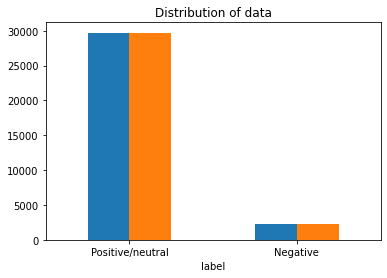

In [6]:
# Wykres dystrybucji danych
ax = df_raw.groupby('label').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Positive/neutral','Negative'], rotation=0)
text, sentiment = list(df_raw['tweet']), list(df_raw['label'])

In [7]:
!pip install num2words -q
from num2words import num2words

In [8]:
#Preprocesowanie
df_raw['tweet'].drop_duplicates(keep='first', inplace=True)
data=df_raw[['tweet','label']]
data_pos = data[data['label'] == 0]
data_neg = data[data['label'] == 1]
dataset = pd.concat([data_pos, data_neg])

In [9]:
stop_words = stopwords.words("english")
punctuation = string.punctuation + '¿'
dataset['tweet']=dataset['tweet'].str.lower()
dataset['tweet'].tail()

31934    lady banned from kentucky mall. @user  #jcpenn...
31946    @user omfg i'm offended! i'm a  mailbox and i'...
31947    @user @user you don't have the balls to hashta...
31948     makes you ask yourself, who am i? then am i a...
31960    @user #sikh #temple vandalised in in #calgary,...
Name: tweet, dtype: object

In [10]:
STOPWORDS = set(stop_words)
STOPWORDS = STOPWORDS.update(["¦", "ð"])

def clean_text(text):
  text = text.lower()
  text = text.replace('<br />', '')
  text = text.replace('¦','')
  text = text.replace('ð','')
  translator = str.maketrans('', '', punctuation)
  text = text.translate(translator)
  text = " ".join([word for word in text.split() if word not in stop_words])
  text = numtowords(text)
  text = " ".join([word for word in text.split() if len(word) > 2])
  return text

In [11]:
def numtowords(text):
  for word in text:
    if re.search(r'\d+', word):
      digits = re.findall(r'\d+', word)
      for digit in digits:
        text = re.sub(digit, num2words(digit, lang='en'), text)
  return text

In [12]:
dataset['clean_text'] = dataset['tweet'].apply(clean_text)
dataset.tail()

,tweet,label,clean_text
31934,lady banned from kentucky mall. @user #jcpenn...,1,lady banned kentucky mall user jcpenny kentucky
31946,@user omfg i'm offended! i'm a mailbox and i'...,1,user omfg offended mailbox proud mailboxpride ...
31947,@user @user you don't have the balls to hashta...,1,user user dont balls hashtag say weasel away l...
31948,"makes you ask yourself, who am i? then am i a...",1,makes ask anybody god thank god
31960,"@user #sikh #temple vandalised in in #calgary,...",1,user sikh temple vandalised calgary wso condem...


In [13]:
def replace_non_ascii(text):
  return ''.join([i if ord(i) < 128 else ' ' for i in text])

In [14]:
dataset['clean_text'] = dataset['clean_text'].apply(replace_non_ascii)
dataset.tail()

,tweet,label,clean_text
31934,lady banned from kentucky mall. @user #jcpenn...,1,lady banned kentucky mall user jcpenny kentucky
31946,@user omfg i'm offended! i'm a mailbox and i'...,1,user omfg offended mailbox proud mailboxpride ...
31947,@user @user you don't have the balls to hashta...,1,user user dont balls hashtag say weasel away l...
31948,"makes you ask yourself, who am i? then am i a...",1,makes ask anybody god thank god
31960,"@user #sikh #temple vandalised in in #calgary,...",1,user sikh temple vandalised calgary wso condem...


In [15]:
nltk.download('omw-1.4')

lemma = WordNetLemmatizer()
def lem(text):
  return [lemma.lemmatize(word, nltk.corpus.reader.wordnet.VERB) for word in nltk.wordpunct_tokenize(text)]

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [16]:
dataset['clean_lem_text'] = dataset['clean_text'].apply(lem)
dataset.tail()

,tweet,label,clean_text,clean_lem_text
31934,lady banned from kentucky mall. @user #jcpenn...,1,lady banned kentucky mall user jcpenny kentucky,"[lady, ban, kentucky, mall, user, jcpenny, ken..."
31946,@user omfg i'm offended! i'm a mailbox and i'...,1,user omfg offended mailbox proud mailboxpride ...,"[user, omfg, offend, mailbox, proud, mailboxpr..."
31947,@user @user you don't have the balls to hashta...,1,user user dont balls hashtag say weasel away l...,"[user, user, dont, ball, hashtag, say, weasel,..."
31948,"makes you ask yourself, who am i? then am i a...",1,makes ask anybody god thank god,"[make, ask, anybody, god, thank, god]"
31960,"@user #sikh #temple vandalised in in #calgary,...",1,user sikh temple vandalised calgary wso condem...,"[user, sikh, temple, vandalise, calgary, wso, ..."


# **2. Modele ML**

In [17]:
#wektoryzacja
X=dataset.clean_lem_text
y=dataset.label
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=5000, lowercase=False, preprocessor=' '.join)
vec_data = vectoriser.fit_transform(dataset.clean_lem_text).toarray()
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  5000


In [18]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(vec_data,y,test_size = 0.1, random_state =26105111)

## **2.1 - Logistic Regression**

In [19]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, y_pred)*100
cf_matrix = confusion_matrix(y_test,y_pred)
print("Logistic Regression")
print('Accuracy Score: %0.3f' % accuracy, '%')
Counter(y_pred)

Logistic Regression
Accuracy Score: 95.746 %


Counter({0: 3096, 1: 101})

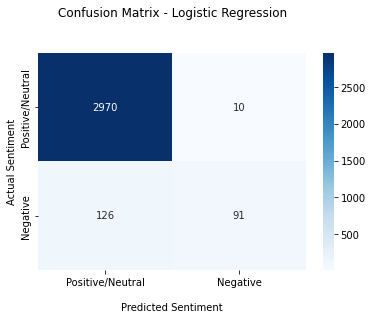

In [21]:
#Confusion Matrix
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix - Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Sentiment')
ax.set_ylabel('Actual Sentiment');

ax.xaxis.set_ticklabels(['Positive/Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive/Neutral','Negative'])

plt.show()

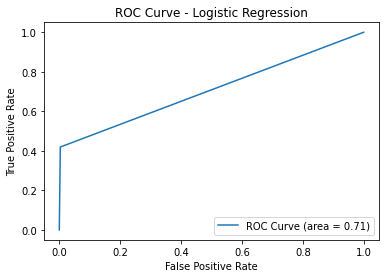

In [22]:
#ROC Curve

fpr, tpr, _ = roc_curve(y_test,  y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.title('ROC Curve - Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

## **2.2 - K Nearest Neighbours**

In [23]:
KNN = KNeighborsClassifier(n_neighbors = 3)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)*100
cf_matrix = confusion_matrix(y_test,y_pred)
print('K Nearest Neighbors (NN = 3)')
print('Accuracy Score: %0.3f' % accuracy, '%')
Counter(y_pred)

K Nearest Neighbors (NN = 3)
Accuracy Score: 95.120 %


Counter({0: 3102, 1: 95})

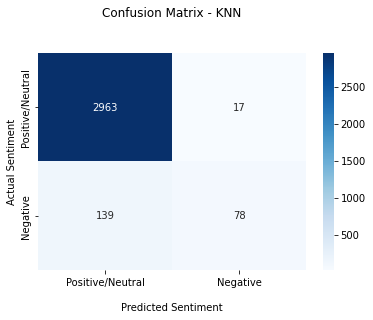

In [24]:
#Confusion Matrix
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix - KNN\n\n');
ax.set_xlabel('\nPredicted Sentiment')
ax.set_ylabel('Actual Sentiment');

ax.xaxis.set_ticklabels(['Positive/Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive/Neutral','Negative'])

plt.show()

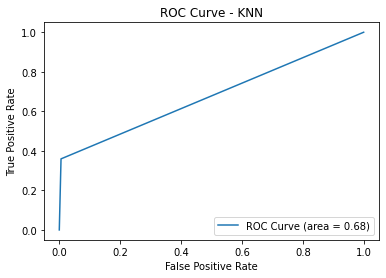

In [25]:
#ROC Curve

fpr, tpr, _ = roc_curve(y_test,  y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.title('ROC Curve - KNN')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

## **2.3 - Multinominal Naive Bayes**

In [26]:
NB = MultinomialNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)*100
cf_matrix = confusion_matrix(y_test,y_pred)
print('Multinominal Naive Bayes')
print('Accuracy Score: %0.3f' % accuracy, '%')
Counter(y_pred)

Multinominal Naive Bayes
Accuracy Score: 95.652 %


Counter({0: 3099, 1: 98})

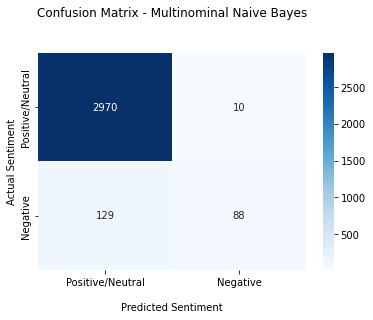

In [27]:
#Confusion Matrix
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix - Multinominal Naive Bayes\n\n');
ax.set_xlabel('\nPredicted Sentiment')
ax.set_ylabel('Actual Sentiment');

ax.xaxis.set_ticklabels(['Positive/Neutral','Negative'])
ax.yaxis.set_ticklabels(['Positive/Neutral','Negative'])

plt.show()

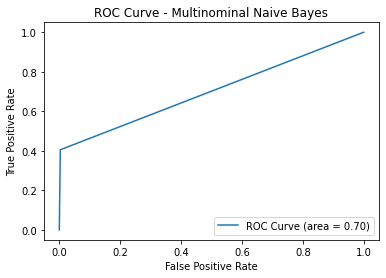

In [28]:
#ROC Curve

fpr, tpr, _ = roc_curve(y_test,  y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.title('ROC Curve - Multinominal Naive Bayes')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

# **3. Model NN**

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

X=dataset.clean_lem_text
y=dataset.label
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=50, lowercase=False, preprocessor=' '.join)
vec_data = vectoriser.fit_transform(dataset.clean_lem_text).toarray()
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

X_train, X_test, y_train, y_test = train_test_split(vec_data,y,test_size = 0.1, random_state =26105111)

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(200, embedding_vector_length, input_length=50))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

No. of feature_words:  50
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 32)            6400      
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 50, 32)           0         
 lDropout1D)                                                     
                                                                 
 lstm_9 (LSTM)               (None, 10)                1720      
                                                                 
 dropout_9 (Dropout)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 8,131
Trainable params: 8,131
Non-trainable params: 0
__________________________

In [54]:
checkpoint = ModelCheckpoint('best_model.hdf5', 
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='auto',
                              period=1,
                              save_weights_only=False)

history = model.fit(X_train,y_train,validation_split=0.2, epochs=5, batch_size=32, callbacks=[checkpoint])

Epoch 1/5
720/720 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.9288
Epoch 1: val_accuracy improved from -inf to 0.93273, saving model to best_model.hdf5
720/720 [==============================] - 111s 61ms/step - loss: 0.2759 - accuracy: 0.9288 - val_loss: 0.2465 - val_accuracy: 0.9327
Epoch 2/5
719/720 [============================>.] - ETA: 0s - loss: 0.2623 - accuracy: 0.9288
Epoch 2: val_accuracy did not improve from 0.93273
720/720 [==============================] - 43s 60ms/step - loss: 0.2623 - accuracy: 0.9288 - val_loss: 0.2468 - val_accuracy: 0.9327
Epoch 3/5
720/720 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.9288
Epoch 3: val_accuracy did not improve from 0.93273
720/720 [==============================] - 41s 57ms/step - loss: 0.2631 - accuracy: 0.9288 - val_loss: 0.2465 - val_accuracy: 0.9327
Epoch 4/5
720/720 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.9288
Epoch 4: val_accuracy did not imp

In [56]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.hdf5")
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

100/100 - 2s - loss: 0.2481 - accuracy: 0.9321 - 2s/epoch - 21ms/step
Model accuracy:  0.9321238398551941


# **Podsumowanie**

Dokonałem czyszczenia, lematyzacji i wektoryzacji danych. 

Użyty przeze mnie zbiór danych jest bardzo niezrównoważony pod kątem liczebności poszczególnych klas. Klasa '0' oznacza tweety bez nacechowania rasistowskiego / seksistowskiego, a więc jest to klasa pozytywna / neutralna. Zawiera ona 29720 rekordów. Klasa '1' jest negatywna i liczy 2242 rekordy. 

Mimo to wszystkie użyte przeze mnie modele ML dobrze poradziły sobie z analizą sentymentu osiągając accuracy > 95%. Pole pod ROC Curve miało największą wartość dla Regresji Logistycznej. 

Dla modelu NN opartego na strukturze LSTM musiałem znacznie zmniejszyć liczbę słów do 50 najczęściej występujących (dla pozostałych modeli było to 5000) i co za tym idzie liczbę parametrów parametrów. Po zaledwie 5 epokach majlepszy sposród stworzonych modeli osiągnął accuracy na poziomie 93%. Lepszy wynik dałoby się z pewnością uzyskać zwiększając liczbę parametrów oraz epok.